# **Predictive Analytics - Time Series Analysis and Forecasting**
**<span style="text-align: center">Author - @attharvaj</span>**


---



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import multiprocessing as mp
import gc
import datetime
from sklearn.preprocessing import LabelEncoder
import calendar
from scipy.sparse import csr_matrix,hstack
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from tqdm import tqdm
import pickle
import sys
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import plotly.graph_objects as go


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!cp /content/gdrive/MyDrive/PredictiveAnalyticsData/utility/generate_submission_file.py .

In [ ]:
from generate_submission_file import generate_submission

Mounted at /content/gdrive
Training Data Shape: (58327370, 43)
Testing Data Shape: (853720, 43)
Prediction Data Shape: (853720, 43)


#### Get the training features and the target variable for train, test and prediction datasets

In [ ]:
def separate_features_and_parameters():
  df = pd.read_pickle("/content/gdrive/MyDrive/PredictiveAnalyticsData/output_data/final_train.pkl")
  # train_df = df.drop(columns=['id'], axis=1)
  train_df = df.copy()
  print(f"Training Data Shape: {train_df.shape}")
  y_train = train_df['sales']
  X_train = train_df.drop(columns=['sales'], axis=1)
  X_train[['id','sold_lag_7', 'sold_lag_14', 'sold_lag_21', 'sold_lag_28', 'sold_lag_35', 'sold_lag_42', 'sold_lag_49', 'sold_lag_56', 'roll_mean_7', 'roll_mean_14', 'roll_mean_28']] = X_train[['id', 'sold_lag_7', 'sold_lag_14', 'sold_lag_21', 'sold_lag_28', 'sold_lag_35', 'sold_lag_42', 'sold_lag_49', 'sold_lag_56', 'roll_mean_7', 'roll_mean_14', 'roll_mean_28']].fillna(0.0)

  df = pd.read_pickle("/content/gdrive/MyDrive/PredictiveAnalyticsData/output_data/final_test.pkl")
  # test_df = df.drop(columns=['id'], axis=1)
  test_df = df.copy()
  print(f"Testing Data Shape: {test_df.shape}")
  y_test = test_df['sales']
  X_test = test_df.drop(columns=['sales'], axis=1)
  X_test[['id','sold_lag_7', 'sold_lag_14', 'sold_lag_21', 'sold_lag_28', 'sold_lag_35', 'sold_lag_42', 'sold_lag_49', 'sold_lag_56', 'roll_mean_7', 'roll_mean_14', 'roll_mean_28']] = X_test[['id', 'sold_lag_7', 'sold_lag_14', 'sold_lag_21', 'sold_lag_28', 'sold_lag_35', 'sold_lag_42', 'sold_lag_49', 'sold_lag_56', 'roll_mean_7', 'roll_mean_14', 'roll_mean_28']].fillna(0.0)

  df = pd.read_pickle("/content/gdrive/MyDrive/PredictiveAnalyticsData/output_data/final_prediction_data.pkl")
  # prediction_df = df.drop(columns=['id'], axis=1)
  prediction_df = df.copy()
  print(f"Prediction Data Shape: {prediction_df.shape}")
  y_prediction = prediction_df['sales']
  X_prediction = prediction_df.drop(columns=['sales'], axis=1)
  X_prediction[['id','sold_lag_7', 'sold_lag_14', 'sold_lag_21', 'sold_lag_28', 'sold_lag_35', 'sold_lag_42', 'sold_lag_49', 'sold_lag_56', 'roll_mean_7', 'roll_mean_14', 'roll_mean_28']] = X_prediction[['id', 'sold_lag_7', 'sold_lag_14', 'sold_lag_21', 'sold_lag_28', 'sold_lag_35', 'sold_lag_42', 'sold_lag_49', 'sold_lag_56', 'roll_mean_7', 'roll_mean_14', 'roll_mean_28']].fillna(0.0)

  del df

  return X_train, y_train, X_test, y_test, X_prediction, y_prediction

In [ ]:
X_train, y_train, X_test, y_test, X_prediction, y_prediction = separate_features_and_parameters()

Training Data Shape: (58327370, 43)
Testing Data Shape: (853720, 43)
Prediction Data Shape: (853720, 43)


In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_prediction.shape, y_prediction.shape

((58327370, 42), (58327370,), (853720, 42), (853720,), (853720, 42), (853720,))

Creating TimeSeries splits for cross-validation

In [ ]:
tscv = TimeSeriesSplit(n_splits=5).split(train_df)

In [ ]:
param_search = {'learning_rate': [0.01, 0.05, 0.1],
                'n_estimators': [100, 200, 300]}

In [ ]:
gsearch = GridSearchCV(estimator=LGBMRegressor(n_jobs=3), cv=tscv, param_grid=param_search, scoring="neg_mean_squared_error")

# rsearch = RandomizedSearchCV(
#     estimator=LGBMRegressor(),
#     param_distributions=param_search,
#     n_iter=10,  # Number of parameter settings sampled
#     scoring='neg_mean_squared_error',  # Adjust scoring based on your task
#     n_jobs=-1,  # Set to -1 for parallel execution
#     cv=tscv,  # Number of cross-validation folds
#     verbose=1,
#     random_state=42
# )

In [ ]:
gsearch.fit(X_train, y_train)
# rsearch.fit(X, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.987289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3918
[LightGBM] [Info] Number of data points in the train set: 9721230, number of used features: 41
[LightGBM] [Info] Start training from score 0.859801
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.369042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3959
[LightGBM] [Info] Number of data points in the train set: 19442458, number of used features: 41
[LightGBM] [Info] Start training from score 0.966739
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.492113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not 

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7bb970a95380>,
             estimator=LGBMRegressor(n_jobs=3),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [ ]:
gsearch.cv_results_
# rsearch.cv_results_

{'mean_fit_time': array([170.97297125, 286.61003151, 389.21095281, 146.50244803,
        224.01364279, 303.73159652, 133.69446039, 208.49621353,
        283.48780661]),
 'std_fit_time': array([ 84.30378266, 142.6404761 , 195.23510237,  70.71907825,
        108.22858082, 149.43287784,  63.3004975 , 102.19414192,
        139.00334565]),
 'mean_score_time': array([11.37393951, 20.27409573, 28.46066465, 10.53310304, 16.80867224,
        23.0050755 ,  9.50624981, 15.28135824, 21.13940034]),
 'std_score_time': array([0.48788534, 0.74020055, 0.92315344, 0.27690632, 0.62536311,
        0.8763441 , 0.33534504, 0.77149482, 0.94187082]),
 'param_learning_rate': masked_array(data=[0.01, 0.01, 0.01, 0.05, 0.05, 0.05, 0.1, 0.1, 0.1],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100, 200, 300, 100, 200, 300, 100, 200, 300],
              mask=[False,

In [ ]:

# rsearch.best_params_
gsearch.best_params_

{'learning_rate': 0.05, 'n_estimators': 200}

In [ ]:
# import joblib

# joblib.dump(gsearch, "/content/gdrive/MyDrive/PredictiveAnalyticsData/output_data/gridsearch_output.pkl")

### Model Training - LGBM

In [ ]:
lgbm = LGBMRegressor(learning_rate =  0.05, n_estimators = 200)

lgbm.fit(X_train,y_train)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 6.370755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3930
[LightGBM] [Info] Number of data points in the train set: 58327370, number of used features: 41
[LightGBM] [Info] Start training from score 1.126322


LGBMRegressor(learning_rate=0.05, n_estimators=200)

In [ ]:
pickle.dump(lgbm, open('/content/gdrive/MyDrive/PredictiveAnalyticsData/trained_models/lgbm_model_lr_0.05_ne_200.pkl','wb'))

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

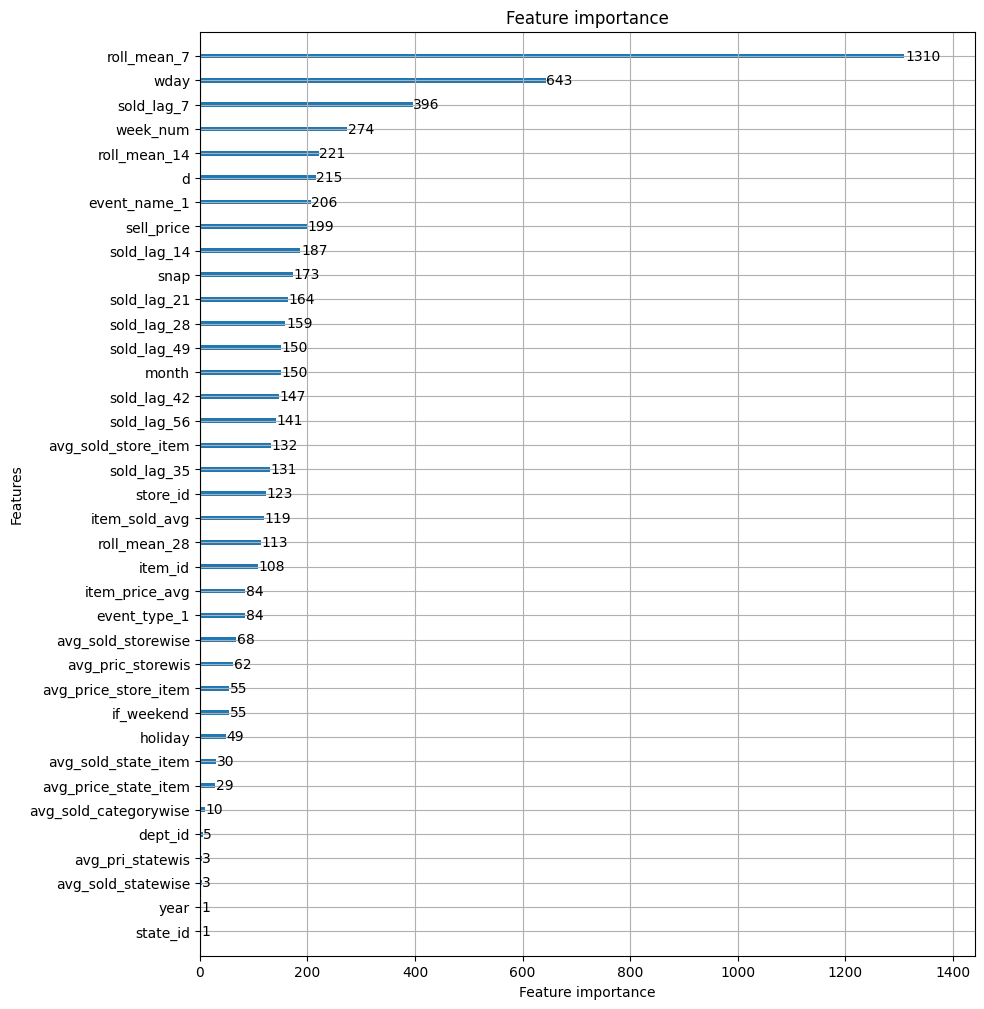

In [ ]:
import lightgbm
lightgbm.plot_importance(lgbm, figsize=(10, 12))

In [ ]:
imp_cols = list(pd.DataFrame({'feature': list(X.columns), 'gain': list(lgbm.feature_importances_)}).sort_values(by='gain', ascending=False).iloc[:10]['feature'])
imp_cols = ['d', 'roll_mean_7', 'wday', 'week_num', 'sold_lag_7', 'sold_lag_14',
            'roll_mean_14', 'event_name_1', 'snap'  'sell_price']

['roll_mean_7',
 'wday',
 'sold_lag_7',
 'week_num',
 'roll_mean_14',
 'd',
 'event_name_1',
 'sell_price',
 'sold_lag_14',
 'snap']

In [ ]:
test_df = pd.read_pickle("/content/gdrive/MyDrive/PredictiveAnalyticsData/output_data/final_test.pkl")
test_df = test_df.drop(columns=['id'], axis=1)

In [ ]:
y_test = test_df['sales']
X_test = test_df.drop(columns=['sales'], axis=1)

In [ ]:
lgbm_pred = lgbm.predict(X_test)

In [ ]:
type(lgbm_pred)
# lgbm_pred.to_pickle("/content/gdrive/MyDrive/PredictiveAnalyticsData/output_data/lgbm_predictions.pkl")

numpy.ndarray

In [ ]:
# Save the NumPy array to a .npy file
np.save('/content/gdrive/MyDrive/PredictiveAnalyticsData/output_data/lgbm.npy', lgbm_pred)

# Load the array back from the .npy file
# loaded_array = np.load('array_data.npy')

In [ ]:
test_df.head()

,item_id,dept_id,cat_id,store_id,state_id,d,sales,week_num,wday,month,...,avg_sold_statewise,avg_sold_categorywise,avg_sold_store_item,avg_sold_state_item,item_price_avg,avg_pric_storewis,avg_pri_statewis,avg_price_catwis,avg_price_store_item,avg_price_state_item
58327370,1437,3,1,0,0,1914,0,13,3,4,...,1.21582,0.561035,0.321533,0.335938,8.296875,4.460938,4.453125,5.554688,8.281250,8.273438
58327371,1438,3,1,0,0,1914,0,13,3,4,...,1.21582,0.561035,0.253906,0.204346,3.968750,4.460938,4.453125,5.554688,3.970703,3.964844
58327372,1439,3,1,0,0,1914,0,13,3,4,...,1.21582,0.561035,0.156982,0.098938,2.966797,4.460938,4.453125,5.554688,2.970703,2.970703
58327373,1440,3,1,0,0,1914,0,13,3,4,...,1.21582,0.561035,1.694336,2.935547,4.503906,4.460938,4.453125,5.554688,4.527344,4.527344
58327374,1441,3,1,0,0,1914,1,13,3,4,...,1.21582,0.561035,0.958984,0.968750,2.882812,4.460938,4.453125,5.554688,2.941406,2.935547


In [ ]:
len(test_df['dept_id'].unique())

7

In [ ]:
test_df.columns

Index(['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales',
       'week_num', 'wday', 'month', 'year', 'event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2', 'holiday', 'if_weekend', 'sell_price',
       'snap', 'sold_lag_7', 'sold_lag_14', 'sold_lag_21', 'sold_lag_28',
       'sold_lag_35', 'sold_lag_42', 'sold_lag_49', 'sold_lag_56',
       'roll_mean_7', 'roll_mean_14', 'roll_mean_28', 'item_sold_avg',
       'avg_sold_storewise', 'avg_sold_statewise', 'avg_sold_categorywise',
       'avg_sold_store_item', 'avg_sold_state_item', 'item_price_avg',
       'avg_pric_storewis', 'avg_pri_statewis', 'avg_price_catwis',
       'avg_price_store_item', 'avg_price_state_item'],
      dtype='object')

In [ ]:
y_pred_df = pd.DataFrame({'pred_sales': list(lgbm_pred)})
y_pred_df.head()
# len(y_pred_df)

,pred_sales
0,0.948806
1,0.138934
2,0.682596
3,1.880550
4,1.742136


In [ ]:
eval_df = pd.concat([test_df[['d', 'sales']].reset_index().drop(columns=['index'], axis=1), y_pred_df], axis=1)
# eval_df['pred_sales'] = eval_df['pred_sales'].round().astype(int)
eval_df = eval_df.groupby('d').sum().reset_index()

In [ ]:
eval_df

,d,sales,pred_sales
0,1914,38793,38193.376500
1,1915,35487,35532.397974
2,1916,34445,35411.100497
3,1917,34732,35444.017213
4,1918,42896,39566.604214
5,1919,50429,48574.285243
6,1920,53032,49964.849577
7,1921,43181,41131.857443
8,1922,44314,40456.883910
9,1923,39601,39390.625504


##### Get Preliminary RMSE

In [ ]:
from sklearn.metrics import mean_squared_error
import math
mse = mean_squared_error(eval_df['sales'], eval_df['pred_sales'])
rmse = math.sqrt(mse)
print(f"Root Mean Square Error:\n{rmse}")

Root Mean Square Error:
2090.6109892827963


In [ ]:
fig = go.Figure()
# Add the first line graph
fig.add_trace(go.Scatter(x=eval_df['d'], y=eval_df['sales'], mode='lines', name='Actual Daily Sales (in units)'))

# Add the second line graph
fig.add_trace(go.Scatter(x=eval_df['d'], y=eval_df['pred_sales'], mode='lines', name='Predicted Daily Sales(in units)'))

# Update layout for better visualization (optional)
fig.update_layout(title='Actual and Predicted Values of Unit Sales', xaxis_title='Day Number', yaxis_title='Unit Sales')

# Show the plot
fig.show()

##### Take 10most important features

In [ ]:
X_train.shape, y_train.shape

((58327370, 41), (58327370,))

###### LGBM Model-2 (With top 10 imp features)

In [ ]:
lgbm_feature_reduced = LGBMRegressor(learning_rate=0.05, n_estimators=200)
features_reduced_model = lgbm_feature_reduced.fit(X_train[imp_cols], y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 5.020159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1282
[LightGBM] [Info] Number of data points in the train set: 58327370, number of used features: 10
[LightGBM] [Info] Start training from score 1.126322


In [ ]:
lgbm_pred_feature_reduced = features_reduced_model.predict(X_test[imp_cols])
lgbm_pred_feature_reduced

array([0.95086107, 0.13807432, 0.67885792, ..., 1.00061044, 2.16228547,
       3.20126659])

In [ ]:
y_pred_df_feature_reduced = pd.DataFrame({'pred_sales': list(lgbm_pred_feature_reduced)})
y_pred_df_feature_reduced.head()

,pred_sales
0,0.950861
1,0.138074
2,0.678858
3,1.873550
4,1.748171


In [ ]:
eval_df_feature_reduced = pd.concat([test_df[['d', 'sales']].reset_index().drop(columns=['index'], axis=1), y_pred_df_feature_reduced], axis=1)
# eval_df['pred_sales'] = eval_df['pred_sales'].round().astype(int)
eval_df_feature_reduced = eval_df_feature_reduced.groupby('d').sum().reset_index()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
eval_df_feature_reduced[['sales', 'pred_sales']] = mms.fit_transform(eval_df_feature_reduced[['sales', 'pred_sales']])

In [ ]:
eval_df_feature_reduced

,d,sales,pred_sales
0,1914,0.170670,0.148570
1,1915,0.040901,0.007284
2,1916,0.000000,0.000217
3,1917,0.011266,0.000000
4,1918,0.331724,0.202645
5,1919,0.627414,0.615242
6,1920,0.729589,0.695835
7,1921,0.342911,0.278440
8,1922,0.387384,0.243564
9,1923,0.202387,0.202895


In [ ]:
from sklearn.metrics import mean_squared_error
import math
mse = mean_squared_error(eval_df_feature_reduced['sales'], eval_df_feature_reduced['pred_sales'])
rmse = math.sqrt(mse)
print(f"Root Mean Square Error:\n{rmse}")

Root Mean Square Error:
0.09490235142121946


### Generate Submission

In [ ]:
pickle.dump(lgbm_feature_reduced, open('/content/gdrive/MyDrive/PredictiveAnalyticsData/trained_models/lgbm_feature_reduced_model_lr_0.05_ne_200.pkl','wb'))

In [ ]:
generate_submission("/content/gdrive/MyDrive/PredictiveAnalyticsData/trained_models/lgbm_model_lr_0.05_ne_200.pkl", take_imp_cols=False)

Generating submission file for model: 
LGBMRegressor at location /content/gdrive/MyDrive/PredictiveAnalyticsData/output_data/sample_submission_new_LGBMRegressor_01122023_222156_.csv



100%|██████████| 28/28 [00:00<00:00, 435.27it/s]


(60980, 29)


#### LightGBM Model - 3

In [ ]:
lgbm3 = LGBMRegressor(learning_rate=0.089 ,num_leaves=146 ,min_data_in_leaf=114)
lgbm3.fit(X_train, y_train)

pickle.dump(lgbm3, open('/content/gdrive/MyDrive/PredictiveAnalyticsData/trained_models/lgbm_model_lr_0.089_nl_146.pkl','wb'))

[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 6.654355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4177
[LightGBM] [Info] Number of data points in the train set: 58327370, number of used features: 42
[LightGBM] [Info] Start training from score 1.126322


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

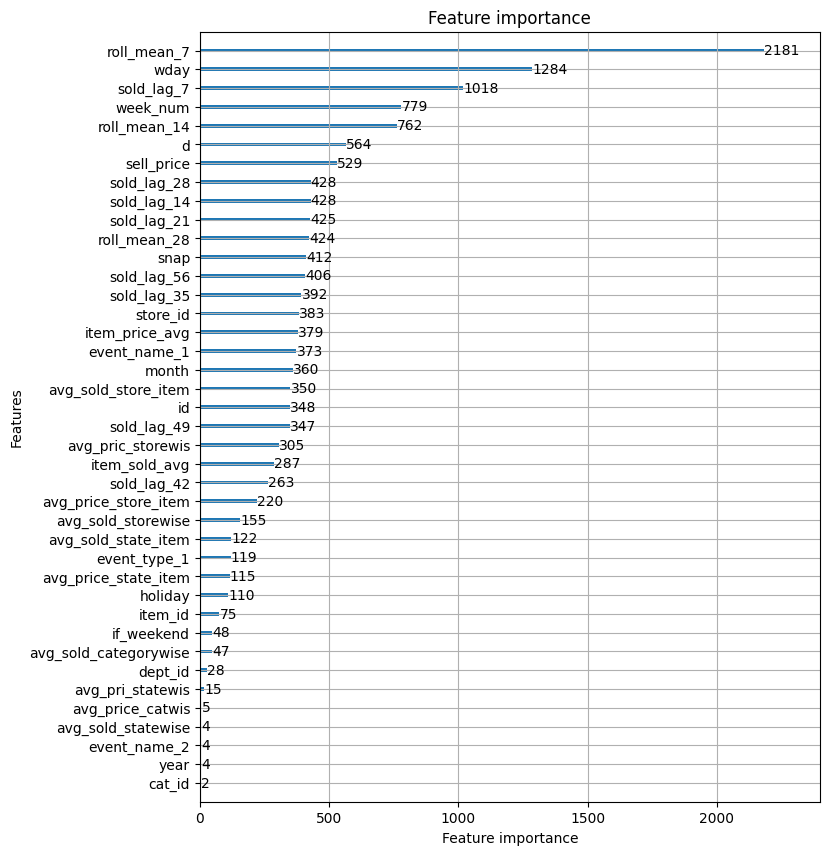

In [ ]:
import lightgbm
lightgbm.plot_importance(lgbm3, figsize=(8, 10))

In [ ]:
imp_cols3 = list(pd.DataFrame({'feature': list(X_train.columns), 'gain': list(lgbm3.feature_importances_)}).sort_values(by='gain', ascending=False).iloc[:10]['feature'])
# imp_cols3 = ['d', 'wday',  'week_num', 'roll_mean_7', 'sold_lag_7', 'roll_mean_14', 'sell_price', 'sold_lag_28', 'roll_mean_28',
#  'sold_lag_21']
imp_cols3

['roll_mean_7',
 'wday',
 'sold_lag_7',
 'week_num',
 'roll_mean_14',
 'd',
 'sell_price',
 'sold_lag_14',
 'sold_lag_28',
 'sold_lag_21']

In [ ]:
generate_submission("/content/gdrive/MyDrive/PredictiveAnalyticsData/trained_models/lgbm_model_lr_0.089_nl_146.pkl", take_imp_cols=False)

[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
Generating submission file for model: 
LGBMRegressor at location /content/gdrive/MyDrive/PredictiveAnalyticsData/output_data/sample_submission_new_LGBMRegressor_03122023_143626_.csv



100%|██████████| 28/28 [00:00<00:00, 439.30it/s]


(60980, 29)


In [ ]:
lgbm3_feature_reduced = LGBMRegressor(learning_rate=0.089 ,num_leaves=146 ,min_data_in_leaf=114)
lgbm3_feature_reduced.fit(X_train[imp_cols3], y_train)

pickle.dump(lgbm3_feature_reduced, open('/content/gdrive/MyDrive/PredictiveAnalyticsData/trained_models/lgbm_feature_reduced_model_lr_0.089_nl_146.pkl','wb'))

[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.096948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1416
[LightGBM] [Info] Number of data points in the train set: 58327370, number of used features: 10
[LightGBM] [Info] Start training from score 1.126322


In [ ]:
generate_submission("/content/gdrive/MyDrive/PredictiveAnalyticsData/trained_models/lgbm_feature_reduced_model_lr_0.089_nl_146.pkl", take_imp_cols=True, imp_cols=imp_cols3)

[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
Generating submission file for model: 
LGBMRegressor at location /content/gdrive/MyDrive/PredictiveAnalyticsData/output_data/sample_submission_new_LGBMRegressor_03122023_144119_with_imp_features.csv



100%|██████████| 28/28 [00:00<00:00, 414.24it/s]


(60980, 29)


##### LightGBM with objective function = tweedie

In [ ]:
lgbm3 = LGBMRegressor(learning_rate=0.089 ,num_leaves=146 ,min_data_in_leaf=114, objective='tweedie')
lgbm3.fit(X_train, y_train)

pickle.dump(lgbm3, open('/content/gdrive/MyDrive/PredictiveAnalyticsData/trained_models/lgbm_model_lr_0.089_nl_146_obj_tweedie.pkl','wb'))

[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 7.254164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4177
[LightGBM] [Info] Number of data points in the train set: 58327370, number of used features: 42
[LightGBM] [Info] Start training from score 0.118958


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

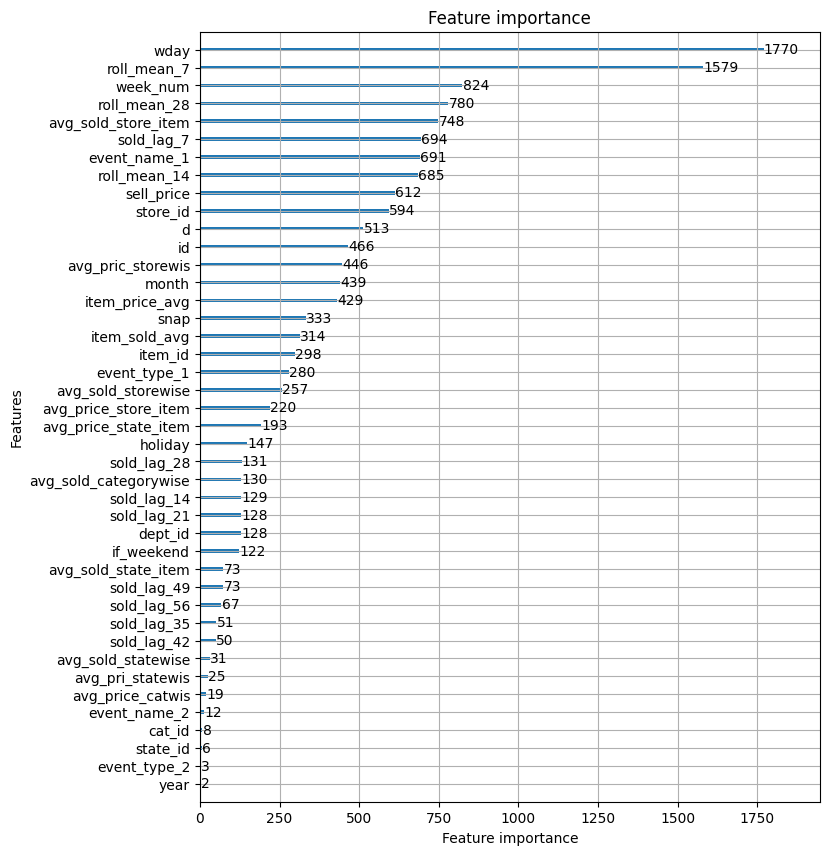

In [ ]:
lightgbm.plot_importance(lgbm3, figsize=(8, 10))

In [ ]:
imp_cols4 = list(pd.DataFrame({'feature': list(X_train.columns), 'gain': list(lgbm3.feature_importances_)}).sort_values(by='gain', ascending=False).iloc[:10]['feature'])
imp_cols3 = ['wday', 'roll_mean_7', 'week_num', 'roll_mean_28',
             'avg_sold_store_item', 'sold_lag_7', 'event_name_1', 'roll_mean_14'
             , 'sell_price', 'store_id']
imp_cols4

['wday',
 'roll_mean_7',
 'week_num',
 'roll_mean_28',
 'avg_sold_store_item',
 'sold_lag_7',
 'event_name_1',
 'roll_mean_14',
 'sell_price',
 'store_id']

In [ ]:
generate_submission("/content/gdrive/MyDrive/PredictiveAnalyticsData/trained_models/lgbm_model_lr_0.089_nl_146_obj_tweedie.pkl", take_imp_cols=False)

[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
[LightGBM] [Warning] min_data_in_leaf is set=114, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=114
Generating submission file for model: 
LGBMRegressor at location /content/gdrive/MyDrive/PredictiveAnalyticsData/output_data/sample_submission_new_LGBMRegressor_03122023_154620_.csv



100%|██████████| 28/28 [00:00<00:00, 451.50it/s]


(60980, 29)
